<a href="https://colab.research.google.com/github/XaviPat01/ML_TechAnalogy_Workshop/blob/main/Major_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Google Play Store Apps- Analysis**
>by Avi Patni, Jashn Tyagi

Dataset source: https://www.kaggle.com/lava18/google-play-store-apps


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn import svm
import random
%matplotlib inline
# from IPython.display import display

In [2]:
pstore_url = "https://raw.githubusercontent.com/XaviPat01/ML_TechAnalogy_Workshop/main/Major%20Project%202/googleplaystore.csv"
# reviews_url = "https://raw.githubusercontent.com/XaviPat01/ML_TechAnalogy_Workshop/main/Major%20Project%202/googleplaystore_user_reviews.csv"

df = pd.read_csv(pstore_url)

In [3]:
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [5]:
columns = df.columns

##Cleaning the Data

In [6]:
unique_val = {}
for column in columns:
  vals = df[column].unique()
  unique_val[column] = vals
  print(column)
  print(vals.shape)
  print(vals)

App
(9660,)
['Photo Editor & Candy Camera & Grid & ScrapBook' 'Coloring book moana'
 'U Launcher Lite – FREE Live Cool Themes, Hide Apps' ...
 'Parkinson Exercices FR' 'The SCP Foundation DB fr nn5n'
 'iHoroscope - 2018 Daily Horoscope & Astrology']
Category
(34,)
['ART_AND_DESIGN' 'AUTO_AND_VEHICLES' 'BEAUTY' 'BOOKS_AND_REFERENCE'
 'BUSINESS' 'COMICS' 'COMMUNICATION' 'DATING' 'EDUCATION' 'ENTERTAINMENT'
 'EVENTS' 'FINANCE' 'FOOD_AND_DRINK' 'HEALTH_AND_FITNESS' 'HOUSE_AND_HOME'
 'LIBRARIES_AND_DEMO' 'LIFESTYLE' 'GAME' 'FAMILY' 'MEDICAL' 'SOCIAL'
 'SHOPPING' 'PHOTOGRAPHY' 'SPORTS' 'TRAVEL_AND_LOCAL' 'TOOLS'
 'PERSONALIZATION' 'PRODUCTIVITY' 'PARENTING' 'WEATHER' 'VIDEO_PLAYERS'
 'NEWS_AND_MAGAZINES' 'MAPS_AND_NAVIGATION' '1.9']
Rating
(41,)
[ 4.1  3.9  4.7  4.5  4.3  4.4  3.8  4.2  4.6  3.2  4.   nan  4.8  4.9
  3.6  3.7  3.3  3.4  3.5  3.1  5.   2.6  3.   1.9  2.5  2.8  2.7  1.
  2.9  2.3  2.2  1.7  2.   1.8  2.4  1.6  2.1  1.4  1.5  1.2 19. ]
Reviews
(6002,)
['159' '967' '87510' ... '

**Inference :**
Some incorrect values:
1. 1.9 in Category
2. nan, 19 (should be a value $\leq$ 5) in Rating
3. Free (should be a number) in Installs
4. nan, 0 in Type
5. Everyone in Price
6. nan in Content Rating
7. February 11,2018 in Genres
8. nan in Android Ver

Other conclusions:
* Sizes are in MB and KB both - Convert to a single unit, remove the M/k from the end, convert to floats
* Price - Remove $ and convert to floats
* Handle duplicate "App"s

In [7]:
df.isna().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

In [8]:
df.dropna(subset = ['Android Ver'], inplace = True)
df.dropna(subset=['Current Ver'], inplace = True)
df.dropna(subset = ['Type'],inplace = True)

In [9]:
app_dp = df[df.duplicated(['App'])]
names = app_dp['App'].unique()
dup_df = pd.DataFrame(columns = columns)
dup_df
for name in names:
  vals = df.loc[df['App']==name,:]
  dup_df = dup_df.append(vals)

In [10]:
dup_df.head(10)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
222,Quick PDF Scanner + OCR FREE,BUSINESS,4.2,80805,Varies with device,"5,000,000+",Free,0,Everyone,Business,"February 26, 2018",Varies with device,4.0.3 and up
229,Quick PDF Scanner + OCR FREE,BUSINESS,4.2,80805,Varies with device,"5,000,000+",Free,0,Everyone,Business,"February 26, 2018",Varies with device,4.0.3 and up
285,Quick PDF Scanner + OCR FREE,BUSINESS,4.2,80804,Varies with device,"5,000,000+",Free,0,Everyone,Business,"February 26, 2018",Varies with device,4.0.3 and up
204,Box,BUSINESS,4.2,159872,Varies with device,"10,000,000+",Free,0,Everyone,Business,"July 31, 2018",Varies with device,Varies with device
236,Box,BUSINESS,4.2,159872,Varies with device,"10,000,000+",Free,0,Everyone,Business,"July 31, 2018",Varies with device,Varies with device
265,Box,BUSINESS,4.2,159872,Varies with device,"10,000,000+",Free,0,Everyone,Business,"July 31, 2018",Varies with device,Varies with device
193,Google My Business,BUSINESS,4.4,70991,Varies with device,"5,000,000+",Free,0,Everyone,Business,"July 24, 2018",2.19.0.204537701,4.4 and up
239,Google My Business,BUSINESS,4.4,70991,Varies with device,"5,000,000+",Free,0,Everyone,Business,"July 24, 2018",2.19.0.204537701,4.4 and up
268,Google My Business,BUSINESS,4.4,70991,Varies with device,"5,000,000+",Free,0,Everyone,Business,"July 24, 2018",2.19.0.204537701,4.4 and up
213,ZOOM Cloud Meetings,BUSINESS,4.4,31614,37M,"10,000,000+",Free,0,Everyone,Business,"July 20, 2018",4.1.28165.0716,4.0 and up


**Inference :**
Certain rows are complete duplicates, whereas some of them have different values in the reviews field

We'll keep the entry with the maximum reviews

In [11]:
names_uniq = set()
clean_df = df.sort_values(by=['Reviews'],ascending = False,inplace=False)
for ind in clean_df.index:
  row = clean_df.loc[ind,:]
  if row['App'] in names_uniq:
    clean_df.drop(index = ind, inplace=True)
  else:
    names_uniq.add(row['App'])
clean_df.shape

(9648, 13)

In [12]:
clean_df.isnull().sum()

App                  0
Category             0
Rating            1458
Reviews              0
Size                 0
Installs             0
Type                 0
Price                0
Content Rating       0
Genres               0
Last Updated         0
Current Ver          0
Android Ver          0
dtype: int64

**Inference :**
Number of nan/null values is considerable in Rating field

We decided to replace the NaN values of the entries with the mean of the respective genre

In [13]:
groups = clean_df[clean_df.isna().any(axis=1)]
mean_vals = {}
df.columns
for name in df['Genres']:
  mean_vals[name] = round(df.loc[df['Genres']==name,'Rating'].mean(),2)
print(mean_vals)

{'Art & Design': 4.38, 'Art & Design;Pretend Play': 3.9, 'Art & Design;Creativity': 4.4, 'Art & Design;Action & Adventure': nan, 'Auto & Vehicles': 4.19, 'Beauty': 4.28, 'Books & Reference': 4.35, 'Business': 4.12, 'Comics': 4.14, 'Comics;Creativity': 4.8, 'Communication': 4.16, 'Dating': 3.97, 'Education;Education': 4.37, 'Education': 4.3, 'Education;Creativity': 4.34, 'Education;Music & Video': 4.2, 'Education;Action & Adventure': 4.3, 'Education;Pretend Play': 4.38, 'Education;Brain Games': 4.43, 'Entertainment': 4.09, 'Entertainment;Music & Video': 4.21, 'Entertainment;Brain Games': 4.33, 'Entertainment;Creativity': 4.53, 'Events': 4.44, 'Finance': 4.13, 'Food & Drink': 4.17, 'Health & Fitness': 4.28, 'House & Home': 4.2, 'Libraries & Demo': 4.18, 'Lifestyle': 4.1, 'Lifestyle;Pretend Play': 4.0, 'Adventure;Action & Adventure': 4.42, 'Arcade': 4.3, 'Casual': 4.15, 'Card': 4.09, 'Casual;Pretend Play': 4.18, 'Action': 4.29, 'Strategy': 4.25, 'Puzzle': 4.39, 'Sports': 4.24, 'Music': 4.

Replacing the NaN values with the means of the respective genres

In [14]:
for ind in clean_df[clean_df.isna().any(axis=1)].index:
  row = clean_df.loc[ind,:]
  genre = row['Genres']
  clean_df.at[ind,'Rating'] = mean_vals[genre]

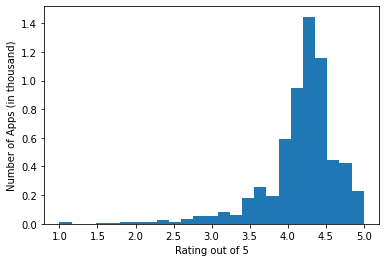

In [15]:
plt.hist(clean_df['Rating'], bins=25, density=True)
plt.xlabel('Rating out of 5')
plt.ylabel('Number of Apps (in thousand)')
plt.show()

In [16]:
clean_df.isnull().sum()

App               0
Category          0
Rating            4
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Last Updated      0
Current Ver       0
Android Ver       0
dtype: int64

Checking whether all the incorrect values have been removed: 

In [17]:
for column in columns:
  print(column)
  print(clean_df[column].unique())

App
['GollerCepte Live Score' 'Ad Block REMOVER - NEED ROOT'
 'SnipSnap Coupon App' ... 'Santa Fe Sentry' 'Lord Fairfax EMS Council'
 'quran-DZ']
Category
['SPORTS' 'TOOLS' 'SHOPPING' 'TRAVEL_AND_LOCAL' 'FAMILY' 'VIDEO_PLAYERS'
 'COMMUNICATION' 'COMICS' 'GAME' 'MEDICAL' 'ENTERTAINMENT'
 'AUTO_AND_VEHICLES' 'PRODUCTIVITY' 'EDUCATION' 'EVENTS' 'PARENTING'
 'PHOTOGRAPHY' 'LIFESTYLE' 'BUSINESS' 'WEATHER' 'BOOKS_AND_REFERENCE'
 'PERSONALIZATION' 'HEALTH_AND_FITNESS' 'NEWS_AND_MAGAZINES' 'DATING'
 'ART_AND_DESIGN' 'FINANCE' 'BEAUTY' 'SOCIAL' 'MAPS_AND_NAVIGATION'
 'FOOD_AND_DRINK' 'LIBRARIES_AND_DEMO' 'HOUSE_AND_HOME']
Rating
[4.2  3.3  4.   4.7  4.3  3.7  4.6  4.5  4.4  3.9  4.1  2.4  3.6  2.9
 4.34 4.8  2.8  3.5  4.13 1.9  3.8  4.17 3.   4.12 3.2  4.9  2.6  3.4
 4.18 5.   2.7  2.   4.24 4.21 2.3  4.28 4.05 4.04  nan 4.09 4.35 4.26
 2.2  2.1  2.5  3.1  1.7  3.97 4.06 4.11 4.15 1.6  3.87 4.38 4.39 4.19
 4.16 4.44 1.5  1.8  1.   1.4  1.2  4.29 4.43 4.25 4.41 4.14]
Reviews
['9992' '999' '9975'

In [18]:
clean_df[clean_df['Android Ver']=="Varies with device"]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
353,MegaFon Dashboard,COMMUNICATION,3.70,99559,Varies with device,"10,000,000+",Free,0,Everyone,Communication,"July 30, 2018",Varies with device,Varies with device
996,Funny Pics,ENTERTAINMENT,3.90,9941,Varies with device,"1,000,000+",Free,0,Teen,Entertainment,"July 7, 2017",Varies with device,Varies with device
861,TV+,ENTERTAINMENT,4.20,98509,Varies with device,"5,000,000+",Free,0,Everyone,Entertainment,"June 28, 2018",Varies with device,Varies with device
4683,"Vault-Hide SMS,Pics & Videos,App Lock,Cloud ba...",BUSINESS,4.50,984451,Varies with device,"50,000,000+",Free,0,Everyone,Business,"August 2, 2018",Varies with device,Varies with device
3630,"Weather by WeatherBug: Forecast, Radar & Alerts",WEATHER,4.50,981995,Varies with device,"10,000,000+",Free,0,Everyone,Weather,"June 7, 2018",Varies with device,Varies with device
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9417,Sensenuts eI,BUSINESS,4.12,0,Varies with device,5+,Free,0,Everyone,Business,"August 2, 2018",Varies with device,Varies with device
6337,BJ's Community SoundBoard,FAMILY,4.09,0,Varies with device,5+,Free,0,Teen,Entertainment,"February 11, 2018",Varies with device,Varies with device
2485,OMD Protocols,MEDICAL,4.19,0,Varies with device,10+,Free,0,Everyone,Medical,"July 27, 2018",1.0,Varies with device
9481,"Period Tracker, Pregnancy Calculator & Calendar 🌸",HEALTH_AND_FITNESS,4.28,0,Varies with device,"10,000+",Free,0,Everyone,Health & Fitness,"August 1, 2018",Varies with device,Varies with device


In [19]:
mean = np.mean(clean_df['Rating'])
median = np.median(clean_df['Rating'])
mode = stats.mode(clean_df['Rating'],axis = None)

print(mean, median, mode)

4.174434881791814 nan ModeResult(mode=array([4.3]), count=array([990]))


## **Data Preprocessing**

In [20]:
clean_df.drop(labels=['Current Ver','Android Ver'], axis =1, inplace= True)

In [21]:
def clninst(x):
  if(type(x)==str):
    x = x.replace(",","").replace("+","")
    return int(x)

def to_int(y):
  return int(y)

def clnprice(y):
  if(y=='0'):
    return 0
  if(type(y)==str):   
    y=y[1:]
    pos = y.index('.')
    left = int(y[0:pos])
    rlen = len(y[pos+1:])
    right = int(y[pos+1:])
    return (left+pow(10,-1*rlen)*right);

# Converting all sizes to MB
def clnsize(z):
  if(z=='Varies with device'):
    return 0;
  val = float(z[:-1])
  if(z[-1]=='M'):
    return val*1000;
  return val;



clean_df['Installs'] = clean_df['Installs'].apply(clninst)
clean_df['Price'] = clean_df['Price'].apply(clnprice).astype('float64')
clean_df['Reviews'] = clean_df['Reviews'].apply(to_int).astype('int64')
clean_df['Size'] = clean_df['Size'].apply(clnsize).astype('float64')

# clean_df['Size'] = clean_df['Size'].str.replace('k','e-3').str.replace('Varies with device','0').astype('float')


In [22]:
clean_df['Size'].unique()

array([3.10e+04, 9.10e+01, 1.80e+04, 3.30e+04, 2.20e+04, 0.00e+00,
       5.50e+03, 1.00e+04, 3.70e+03, 3.80e+04, 9.60e+04, 1.50e+04,
       9.70e+04, 2.80e+03, 2.90e+03, 3.90e+03, 4.90e+04, 3.20e+03,
       7.50e+04, 9.40e+03, 1.90e+04, 7.10e+04, 1.30e+04, 1.10e+03,
       6.60e+03, 6.30e+04, 2.70e+03, 3.90e+04, 5.10e+04, 7.40e+04,
       9.90e+04, 2.70e+04, 4.00e+04, 5.90e+04, 4.50e+03, 3.70e+04,
       5.50e+04, 1.60e+04, 7.00e+04, 7.20e+03, 7.30e+01, 9.70e+03,
       6.30e+03, 2.00e+03, 3.40e+03, 7.20e+02, 9.90e+03, 1.40e+04,
       7.90e+03, 4.50e+04, 2.00e+04, 6.70e+03, 1.30e+03, 8.70e+04,
       1.90e+03, 3.50e+03, 5.98e+02, 2.60e+03, 8.90e+03, 2.30e+04,
       3.60e+03, 2.60e+04, 3.00e+04, 5.10e+03, 5.30e+04, 9.00e+03,
       9.30e+01, 4.10e+03, 2.80e+04, 2.50e+04, 2.50e+03, 3.80e+03,
       1.00e+03, 7.90e+04, 1.20e+04, 5.40e+04, 1.50e+03, 5.80e+03,
       8.20e+04, 4.70e+03, 5.80e+04, 7.60e+03, 6.10e+04, 7.00e+03,
       6.40e+04, 3.10e+03, 1.18e+02, 6.96e+02, 4.40e+04, 1.20e

In [23]:
clean_df.info()
clean_df.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9648 entries, 2989 to 9137
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             9648 non-null   object 
 1   Category        9648 non-null   object 
 2   Rating          9644 non-null   float64
 3   Reviews         9648 non-null   int64  
 4   Size            9648 non-null   float64
 5   Installs        9648 non-null   int64  
 6   Type            9648 non-null   object 
 7   Price           9648 non-null   float64
 8   Content Rating  9648 non-null   object 
 9   Genres          9648 non-null   object 
 10  Last Updated    9648 non-null   object 
dtypes: float64(3), int64(2), object(6)
memory usage: 1.2+ MB


## **Data Visualization**


### **Top 25 Apps with largest number of installs**


In [24]:
def plot_target_by_group(df, target_col, group_col, figsize=(6,4), title=""):
  order = sorted(list(set(df[group_col])))
  stats = df.groupby(group_col).mean()[target_col]
  fig, ax = plt.subplots(figsize=figsize)
  sns.barplot(x=group_col, y=target_col,data=df, ax=ax, order=order).set_title(title)
  ax.set(ylim=(3.0, 5.5))  
  ax.tick_params(labelrotation=90)
  return stats

# def plot_sum_by_group(df,target_col,group_col,order_gp,figsize=(6,4),title=""):
#   order = sorted(list(set(df[group_col])))
#   sns.set(font_scale=1.05)
#   stats = df.groupby(group_col).sum()[target_col]
#   fig,ax = plt.subplots(figsize=figsize)
#   sns.barplot(x=group_col, y=target_col,data=df,ax=ax,order=order).set_title(title)
#   ax.tick_params(labelrotation=90)
#   plt.show()

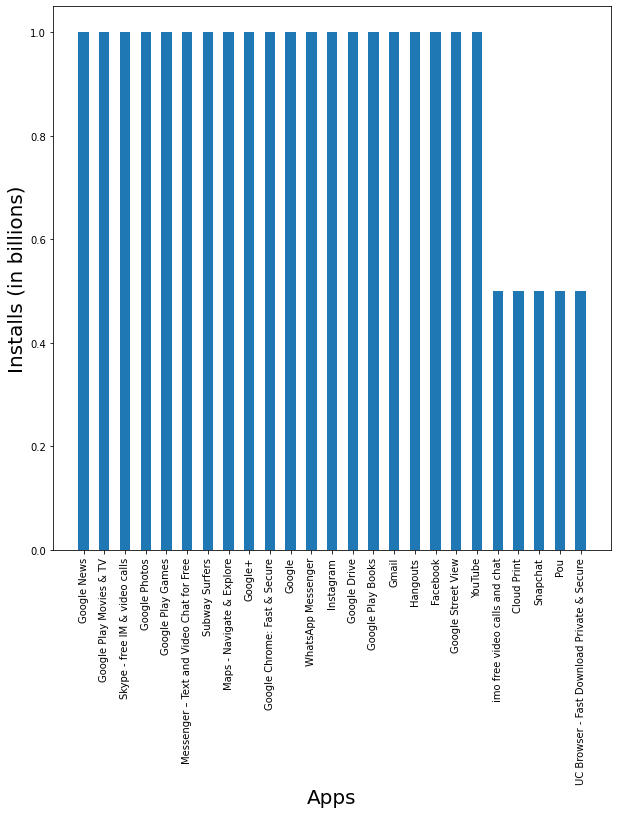

In [25]:
final_result = clean_df.sort_values(by=['Installs'],ascending=False)[:25]
plt.figure(figsize=(10,10))
plt.bar(final_result['App'],final_result['Installs']/1e9,width=0.5)
plt.xlabel('Apps',fontsize=20)
plt.xticks(rotation=90)
plt.ylabel('Installs (in billions)',fontsize=20)
plt.show()

**Inference:** A lot of Google Suite apps are there in the top 25

Facebook is the most downloaded non-Google app, followed by Subway Surfers and WhatsApp

### **Most Popular Category**

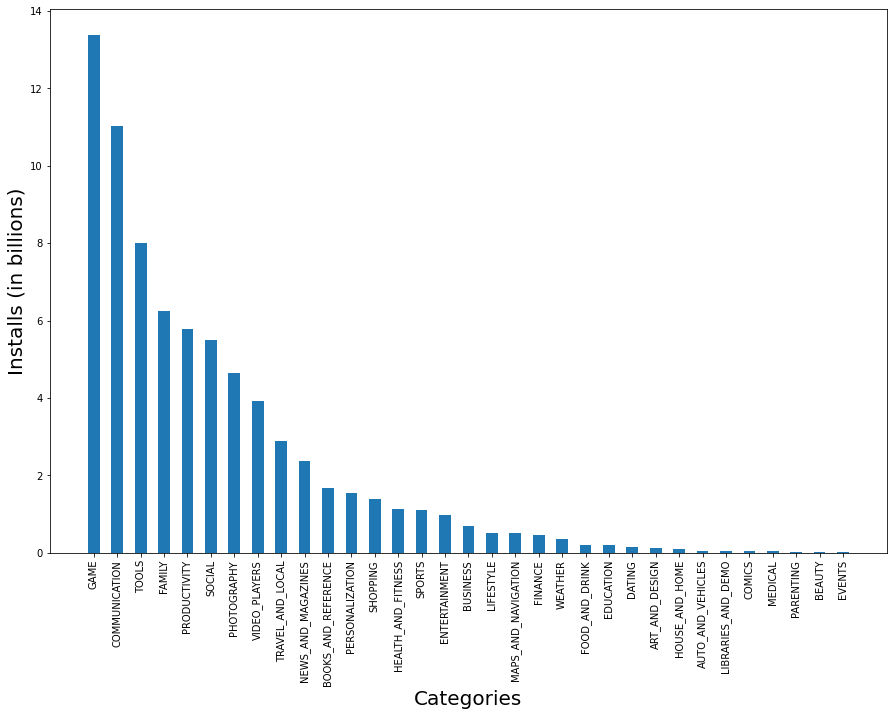

In [26]:
cat_data = clean_df.groupby(by=['Category']).sum().reset_index().sort_values(by=['Installs'],ascending=False)

plt.figure(figsize=(15,10))
plt.bar(cat_data['Category'],cat_data['Installs']/1e9,width=0.5)
plt.xticks(rotation=90)
plt.xlabel("Categories",fontsize=20)
plt.ylabel("Installs (in billions)",fontsize=20)
plt.show()



**Inference :** Games lead the charts for most installs followed by Communication and Tools

Making an app in these categories maybe beneficial

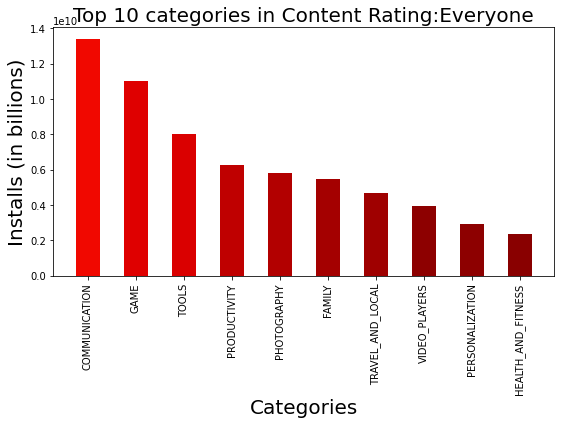

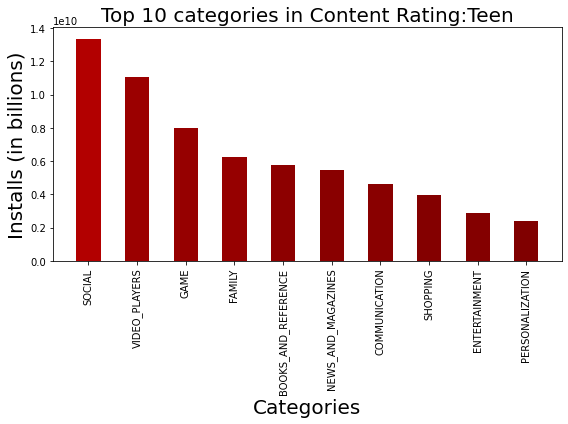

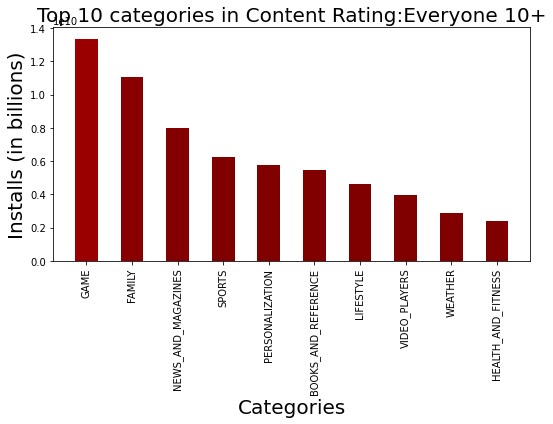

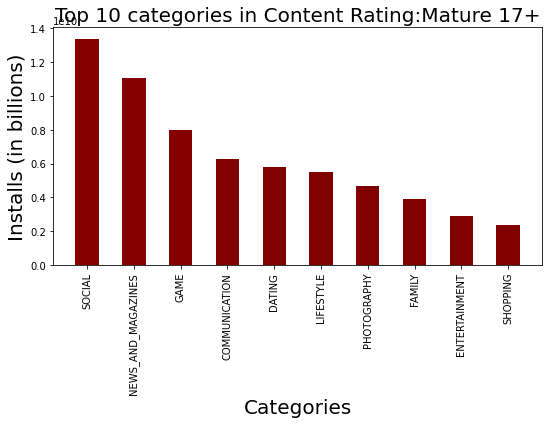

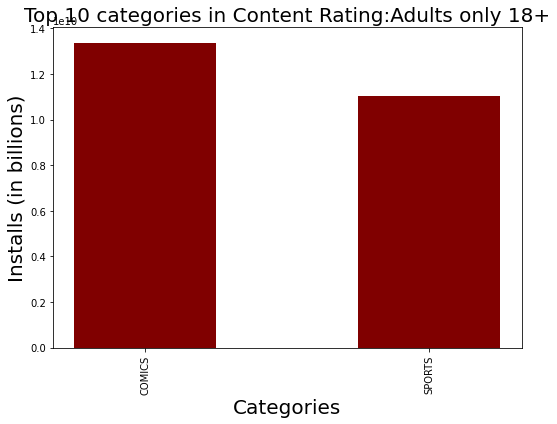

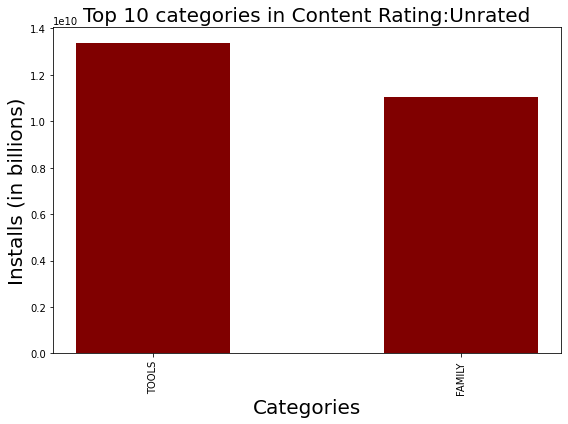

In [27]:
# data = clean_df.groupby(['Content Rating']).sum().reset_index()
# data

my_cmap = cm.get_cmap('jet_r')
my_norm = Normalize(vmin=0,vmax=1e11)


for name in clean_df['Content Rating'].unique():
  data = clean_df[clean_df['Content Rating']==name].groupby(by=['Category']).sum().reset_index().sort_values(by=['Installs'],ascending=False)
  plt.figure(figsize=(8,6))
  size=min(data['Installs'].shape[0],10)
  plt.bar(data['Category'][:size],cat_data['Installs'][:size],width=0.5,color=my_cmap(my_norm(data['Installs'])))
  plt.xticks(rotation=90)
  plt.xlabel("Categories",fontsize=20)
  plt.ylabel("Installs (in billions)",fontsize=20)
  plt.title(f"Top 10 categories in Content Rating:{name}",fontsize=20)
  plt.tight_layout()
  plt.show()

### **Free v/s Paid**


In [28]:
cost_data = clean_df.groupby(['Type']).sum().reset_index()
cost_data[['Type','Installs']]

,Type,Installs
0,Free,75090036446
1,Paid,57313671


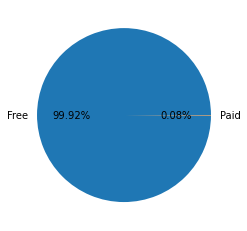

In [29]:
plt.pie(cost_data['Installs'],labels = cost_data['Type'],autopct="%1.2f%%")
plt.show()

**Inference:** As predicted, Free apps are installed more than paid

The developer has either the following sources of earning in free apps:
* Ad-revenue
* In-app purchases
* Freemium model


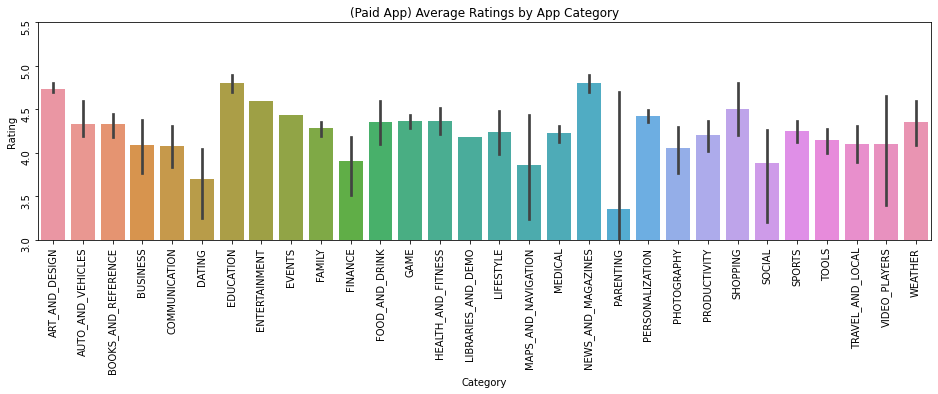

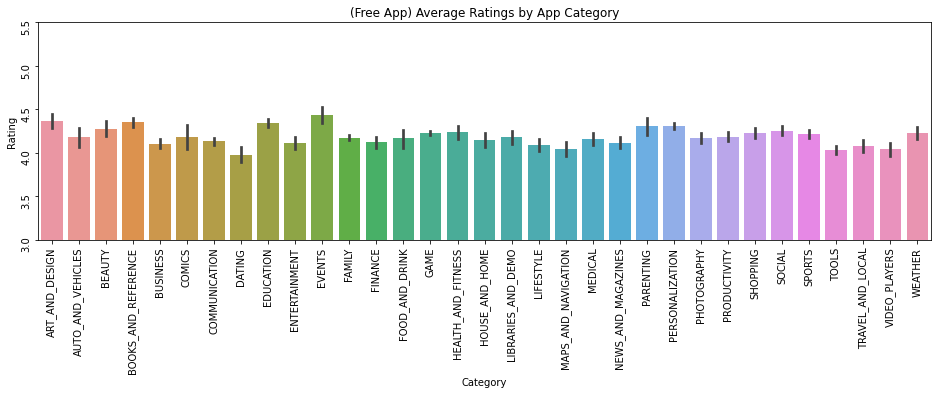

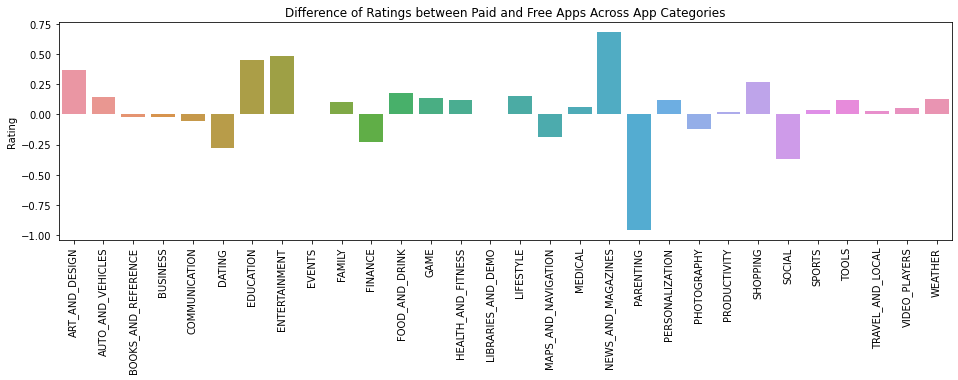

In [30]:
data_filter = clean_df[['Type','Category','Rating']]
paid_stats = plot_target_by_group(data_filter.query('Type == "Paid"'), 'Rating', 'Category', (16, 4), "(Paid App) Average Ratings by App Category")
free_stats = plot_target_by_group(data_filter.query('Type == "Free"'), 'Rating', 'Category', (16, 4), "(Free App) Average Ratings by App Category")


fig, ax = plt.subplots(figsize=(16,4))
sorted_idx = sorted(paid_stats.index)
rating_diff = paid_stats[sorted_idx] - free_stats[sorted_idx]
g = sns.barplot(x=sorted_idx, y=rating_diff, ax=ax)
g.set_title("Difference of Ratings between Paid and Free Apps Across App Categories");

g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()

**Inference:** In general, paid apps are rated better than free apps

In [31]:
data = clean_df[clean_df['Type']=='Paid'].sort_values(by=['Price','Installs'],ascending= False)
data[:25]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated
4367,I'm Rich - Trump Edition,LIFESTYLE,3.60,275,7300.0,10000,Paid,400.00,Everyone,Lifestyle,"May 3, 2018"
5351,I am rich,LIFESTYLE,3.80,3547,1800.0,100000,Paid,399.99,Everyone,Lifestyle,"January 12, 2018"
5356,I Am Rich Premium,FINANCE,4.10,1867,4700.0,50000,Paid,399.99,Everyone,Finance,"November 12, 2017"
5354,I am Rich Plus,FAMILY,4.00,856,8700.0,10000,Paid,399.99,Everyone,Entertainment,"May 19, 2018"
4362,💎 I'm rich,LIFESTYLE,3.80,718,26000.0,10000,Paid,399.99,Everyone,Lifestyle,"March 11, 2018"
5359,I am rich(premium),FINANCE,3.50,472,965.0,5000,Paid,399.99,Everyone,Finance,"May 1, 2017"
5362,I Am Rich Pro,FAMILY,4.40,201,2700.0,5000,Paid,399.99,Everyone,Entertainment,"May 30, 2017"
5369,I am Rich,FINANCE,4.30,180,3800.0,5000,Paid,399.99,Everyone,Finance,"March 22, 2018"
5358,I am Rich!,FINANCE,3.80,93,22000.0,1000,Paid,399.99,Everyone,Finance,"December 11, 2017"
5373,I AM RICH PRO PLUS,FINANCE,4.00,36,41000.0,1000,Paid,399.99,Everyone,Finance,"June 25, 2018"


**Inference:** The costliest 25 apps don't have a lot of installs. 
Let's plot the rest and see their distribution 

In [32]:
data = clean_df[clean_df['Type']=='Paid'].sort_values(by=['Installs','Price'],ascending= False)
data[:10]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated
2241,Minecraft,FAMILY,4.5,2376564,0.0,10000000,Paid,6.99,Everyone 10+,Arcade;Action & Adventure,"July 24, 2018"
4034,Hitman Sniper,GAME,4.6,408292,29000.0,10000000,Paid,0.99,Mature 17+,Action,"July 12, 2018"
7417,Grand Theft Auto: San Andreas,GAME,4.4,348962,26000.0,1000000,Paid,6.99,Mature 17+,Action,"March 21, 2015"
2883,Facetune - For Free,PHOTOGRAPHY,4.4,49553,48000.0,1000000,Paid,5.99,Everyone,Photography,"July 25, 2018"
5578,Sleep as Android Unlock,LIFESTYLE,4.5,23966,872.0,1000000,Paid,5.99,Everyone,Lifestyle,"June 27, 2018"
8804,DraStic DS Emulator,GAME,4.6,87766,12000.0,1000000,Paid,4.99,Everyone,Action,"July 19, 2016"
7355,Threema,COMMUNICATION,4.5,51110,0.0,1000000,Paid,2.99,Everyone,Communication,"August 3, 2018"
9941,Tasker,TOOLS,4.6,43045,0.0,1000000,Paid,2.99,Everyone,Tools,"June 25, 2018"
8860,Bloons TD 5,FAMILY,4.6,190086,94000.0,1000000,Paid,2.99,Everyone,Strategy,"July 13, 2018"
2242,Card Wars - Adventure Time,FAMILY,4.3,129603,23000.0,1000000,Paid,2.99,Everyone 10+,Card;Action & Adventure,"February 11, 2016"


**Inference:** In paid apps, games and family dominate top 10 installs

## **Data Preparation**

Encoding the categorical data to integers for the rating predictor models

In [33]:
clean_df.info()
data = clean_df.drop(labels=['App','Last Updated'],axis=1)
data[data['Category']==0]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9644 entries, 2989 to 9137
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             9644 non-null   object 
 1   Category        9644 non-null   object 
 2   Rating          9644 non-null   float64
 3   Reviews         9644 non-null   int64  
 4   Size            9644 non-null   float64
 5   Installs        9644 non-null   int64  
 6   Type            9644 non-null   object 
 7   Price           9644 non-null   float64
 8   Content Rating  9644 non-null   object 
 9   Genres          9644 non-null   object 
 10  Last Updated    9644 non-null   object 
dtypes: float64(3), int64(2), object(6)
memory usage: 904.1+ KB


,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres


We need to encode category, size, type, content rating and genres to integers

In [34]:
lb_make = LabelEncoder()

data['cat'] = lb_make.fit_transform(data['Category'])
data['crating'] = lb_make.fit_transform(data['Content Rating'])
data['gnr'] = lb_make.fit_transform(data['Genres'])
data['type'] = lb_make.fit_transform(data['Type'])
data['Size'] = data['Size'].astype('int64')
model_data = data.drop(labels=['Content Rating','Type'],axis=1)
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9644 entries, 2989 to 9137
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Category  9644 non-null   object 
 1   Rating    9644 non-null   float64
 2   Reviews   9644 non-null   int64  
 3   Size      9644 non-null   int64  
 4   Installs  9644 non-null   int64  
 5   Price     9644 non-null   float64
 6   Genres    9644 non-null   object 
 7   cat       9644 non-null   int64  
 8   crating   9644 non-null   int64  
 9   gnr       9644 non-null   int64  
 10  type      9644 non-null   int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 904.1+ KB


In [35]:
model_data.head()

,Category,Rating,Reviews,Size,Installs,Price,Genres,cat,crating,gnr,type
2989,SPORTS,4.2,9992,31000,1000000,0.0,Sports,28,1,99,0
4970,TOOLS,3.3,999,91,100000,0.0,Tools,29,1,105,0
2723,SHOPPING,4.2,9975,18000,1000000,0.0,Shopping,26,1,93,0
3079,SPORTS,4.0,9971,33000,1000000,0.0,Sports,28,1,99,0
3229,TRAVEL_AND_LOCAL,4.7,9971,22000,500000,0.0,Travel & Local,30,4,107,0


### Dummy Encoding

In [36]:
data2 = pd.get_dummies(model_data, columns=['Category'])

In [37]:
data2.head()

,Rating,Reviews,Size,Installs,Price,Genres,cat,crating,gnr,type,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,Category_COMICS,Category_COMMUNICATION,Category_DATING,Category_EDUCATION,Category_ENTERTAINMENT,Category_EVENTS,Category_FAMILY,Category_FINANCE,Category_FOOD_AND_DRINK,Category_GAME,Category_HEALTH_AND_FITNESS,Category_HOUSE_AND_HOME,Category_LIBRARIES_AND_DEMO,Category_LIFESTYLE,Category_MAPS_AND_NAVIGATION,Category_MEDICAL,Category_NEWS_AND_MAGAZINES,Category_PARENTING,Category_PERSONALIZATION,Category_PHOTOGRAPHY,Category_PRODUCTIVITY,Category_SHOPPING,Category_SOCIAL,Category_SPORTS,Category_TOOLS,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER
2989,4.2,9992,31000,1000000,0.0,Sports,28,1,99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4970,3.3,999,91,100000,0.0,Tools,29,1,105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2723,4.2,9975,18000,1000000,0.0,Shopping,26,1,93,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3079,4.0,9971,33000,1000000,0.0,Sports,28,1,99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3229,4.7,9971,22000,500000,0.0,Travel & Local,30,4,107,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


## **Models**

For predicting the rating, we're testing two models:
1. Linear Regressor
2. SVR

For each model, we'll use the following sets of input data and compare if there's significant difference:
* With encoded genre label
* Without encoded genre label

### *Step 0*: Setting up the evaluation matrix

In [38]:
def Evaluationmatrix(y_true, y_predict):
    print ('Mean Squared Error: '+ str(metrics.mean_squared_error(y_true,y_predict)))
    print ('Mean Absolute Error: '+ str(metrics.mean_absolute_error(y_true,y_predict)))
    print ('Mean Squared Log Error: '+ str(metrics.mean_squared_log_error(y_true,y_predict)))

In [39]:
#to add into results_index for evaluation of error term 
def Evaluationmatrix_dict(y_true, y_predict, name = 'Linear - Integer'):
    dict_matrix = {}
    dict_matrix['Series Name'] = name
    dict_matrix['Mean Squared Error'] = metrics.mean_squared_error(y_true,y_predict)
    dict_matrix['Mean Absolute Error'] = metrics.mean_absolute_error(y_true,y_predict)
    dict_matrix['Mean Squared Log Error'] = metrics.mean_squared_log_error(y_true,y_predict)
    return dict_matrix

resultsdata = pd.DataFrame()

### Model 1: **Linear Regressor**

#### Case 1: Without encoded genre labels

##### **Step 1**: Training the model

In [40]:
X = model_data.drop(labels = ['Category','Rating','Genres','gnr'],axis = 1)
y = model_data.Rating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
model = LinearRegression()
model.fit(X_train,y_train)
Results = model.predict(X_test)

##### **Step 2**: Adding training results to ResultsData Dataframe

In [41]:
resultsdata = resultsdata.from_dict(Evaluationmatrix_dict(y_test,Results),orient = 'index')
resultsdata = resultsdata.transpose()

##### **Step 3**: Testing the model

In [42]:
#Dummy Encoding
X_d = data2.drop(labels = ['Rating','Genres','cat','gnr'],axis = 1)
y_d = data2.Rating
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d, test_size=0.30)
model_d = LinearRegression()
model_d.fit(X_train_d,y_train_d)
Results_d = model_d.predict(X_test_d)

##### **Step 4**: Adding testing results to Results Dataframe

In [43]:
resultsdata = resultsdata.append(Evaluationmatrix_dict(y_test_d,Results_d, name = 'Linear - Dummy'),ignore_index = True)

##### **Step 5**: Analysing the performance

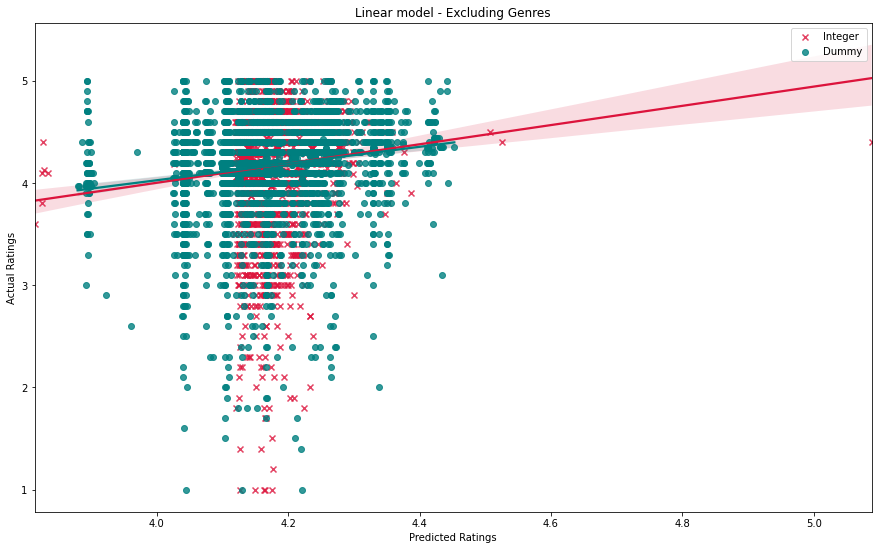

In [44]:
plt.figure(figsize=(15,9))
sns.regplot(x=Results,y=y_test,color='crimson', label = 'Integer', marker = 'x')
sns.regplot(x=Results_d,y=y_test_d,color='teal',label = 'Dummy', marker='o')
plt.legend()
plt.title('Linear model - Excluding Genres')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

In [45]:
print ('Actual mean of population:' + str(y.mean()))
print ('Integer encoding(mean) :' + str(Results.mean()))
print ('Dummy encoding(mean) :'+ str(Results_d.mean()))
print ('Integer encoding(std) :' + str(Results.std()))
print ('Dummy encoding(std) :'+ str(Results_d.std()))

Actual mean of population:4.174434881791814
Integer encoding(mean) :4.175827602705443
Dummy encoding(mean) :4.174930606049054
Integer encoding(std) :0.046587075619560714
Dummy encoding(std) :0.09761475530238108


#### Case 2: With encoded genre labels

##### **Step 1**: Training the model

In [46]:
X = model_data.drop(labels = ['Category','Rating','Genres'],axis = 1)
y = model_data.Rating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
model = LinearRegression()
model.fit(X_train,y_train)
Results = model.predict(X_test)

##### **Step 2**: Adding training results to ResultsData Dataframe

In [47]:
resultsdata = resultsdata.append(Evaluationmatrix_dict(y_test,Results, name = 'Linear(inc Genre) - Integer'),ignore_index = True)

##### **Step 3**: Testing the model

In [48]:
X_d = data2.drop(labels = ['Rating','Genres','cat'],axis = 1)
y_d = data2.Rating
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d, test_size=0.30)
model_d = LinearRegression()
model_d.fit(X_train_d,y_train_d)
Results_d = model_d.predict(X_test_d)

##### **Step 4**: Adding testing results to Results Dataframe

In [49]:
resultsdata = resultsdata.append(Evaluationmatrix_dict(y_test_d,Results_d, name = 'Linear(inc Genre) - Dummy'),ignore_index = True)

##### **Step 5**: Analysing the performance

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


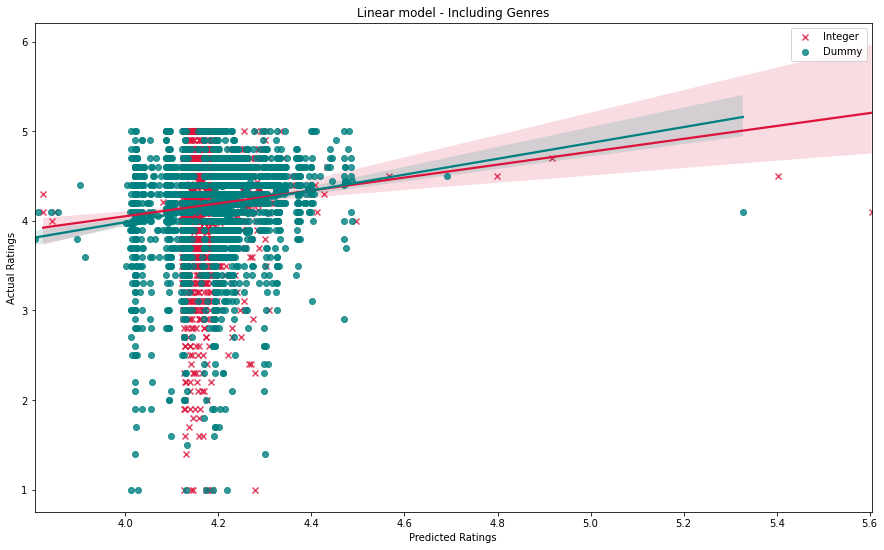

In [50]:
plt.figure(figsize=(15,9))
sns.regplot(Results,y_test,color='crimson', label = 'Integer', marker = 'x')
sns.regplot(Results_d,y_test_d,color='teal',label = 'Dummy',marker='o')
plt.legend()
plt.title('Linear model - Including Genres')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

In [51]:
print ('Integer encoding(mean) :' + str(Results.mean()))
print ('Dummy encoding(mean) :'+ str(Results_d.mean()))
print ('Integer encoding(std) :' + str(Results.std()))
print ('Dummy encoding(std) :'+ str(Results_d.std()))

Integer encoding(mean) :4.173713649323708
Dummy encoding(mean) :4.187417179778593
Integer encoding(std) :0.05822781798822996
Dummy encoding(std) :0.09848047623214536


### Model 2: **Support Vector (Machine) Regressor**

#### Case 1: Without encoded genre labels

We follow the same steps as in Linear Regression

In [52]:
X = model_data.drop(labels = ['Category','Rating','Genres','gnr'],axis = 1)
y = model_data.Rating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

model2 = svm.SVR()
model2.fit(X_train,y_train)

Results2 = model2.predict(X_test)

resultsdata = resultsdata.append(Evaluationmatrix_dict(y_test,Results2, name = 'SVM - Integer'),ignore_index = True)

In [53]:
#dummy based

X_d = data2.drop(labels = ['Rating','Genres','cat','gnr'],axis = 1)
y_d = data2.Rating

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d, test_size=0.30)

model2 = svm.SVR()
model2.fit(X_train_d,y_train_d)

Results2_d = model2.predict(X_test_d)

resultsdata = resultsdata.append(Evaluationmatrix_dict(y_test_d,Results2_d, name = 'SVM - Dummy'),ignore_index = True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


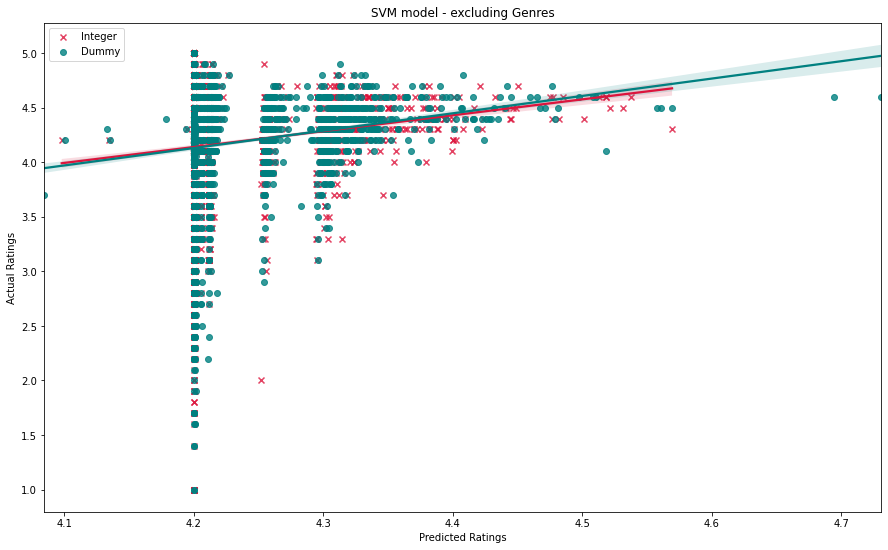

In [54]:
plt.figure(figsize=(15,9))
sns.regplot(Results2,y_test,color='crimson', label = 'Integer', marker = 'x')
sns.regplot(Results2_d,y_test_d,color='teal',label = 'Dummy')
plt.legend()
plt.title('SVM model - excluding Genres')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

In [55]:
print ('Integer encoding(mean) :' + str(Results2.mean()))
print ('Dummy encoding(mean) :'+ str(Results2_d.mean()))
print ('Integer encoding(std) :' + str(Results2.std()))
print ('Dummy encoding(std) :'+ str(Results2_d.std()))

Integer encoding(mean) :4.2237563096623125
Dummy encoding(mean) :4.224860983058136
Integer encoding(std) :0.04917093678205625
Dummy encoding(std) :0.050546424849056866


#### Case 2: With encoded genre labels

In [56]:
model2a = svm.SVR()

X = model_data.drop(labels = ['Category','Rating','Genres'],axis = 1)
y = model_data.Rating

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

model2a.fit(X_train,y_train)

Results2a = model2a.predict(X_test)

resultsdata = resultsdata.append(Evaluationmatrix_dict(y_test,Results2a, name = 'SVM(inc Genres) - Integer'),ignore_index = True)

In [57]:
model2a = svm.SVR()

X_d = data2.drop(labels = ['Rating','Genres','cat'],axis = 1)
y_d = data2.Rating

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d, test_size=0.30)

model2a.fit(X_train_d,y_train_d)

Results2a_d = model2a.predict(X_test_d)

resultsdata = resultsdata.append(Evaluationmatrix_dict(y_test_d,Results2a_d, name = 'SVM(inc Genres) - Dummy'),ignore_index = True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


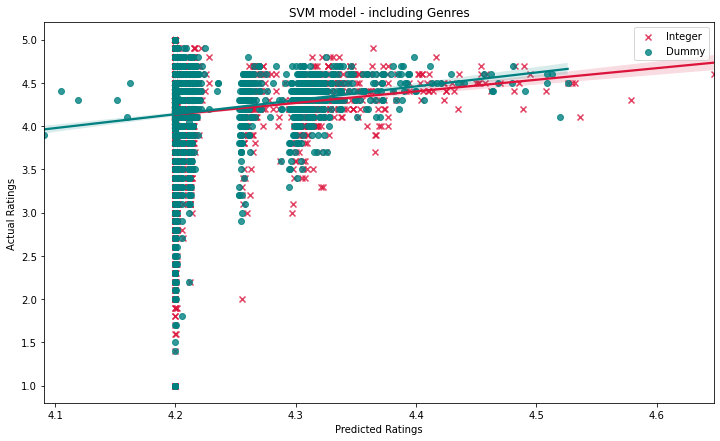

In [58]:
plt.figure(figsize=(12,7))
sns.regplot(Results2a,y_test,color='crimson', label = 'Integer', marker = 'x')
sns.regplot(Results2a_d,y_test_d,color='teal',label = 'Dummy')
plt.legend()
plt.title('SVM model - including Genres')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

In [59]:
print ('Integer encoding(mean) :' + str(Results2a.mean()))
print ('Dummy encoding(mean) :'+ str(Results2a_d.mean()))
print ('Integer encoding(std) :' + str(Results2a.std()))
print ('Dummy encoding(std) :'+ str(Results2a_d.std()))

Integer encoding(mean) :4.225505649228921
Dummy encoding(mean) :4.222903867362595
Integer encoding(std) :0.05138179151691552
Dummy encoding(std) :0.045834987178744


### **Final Analysis**

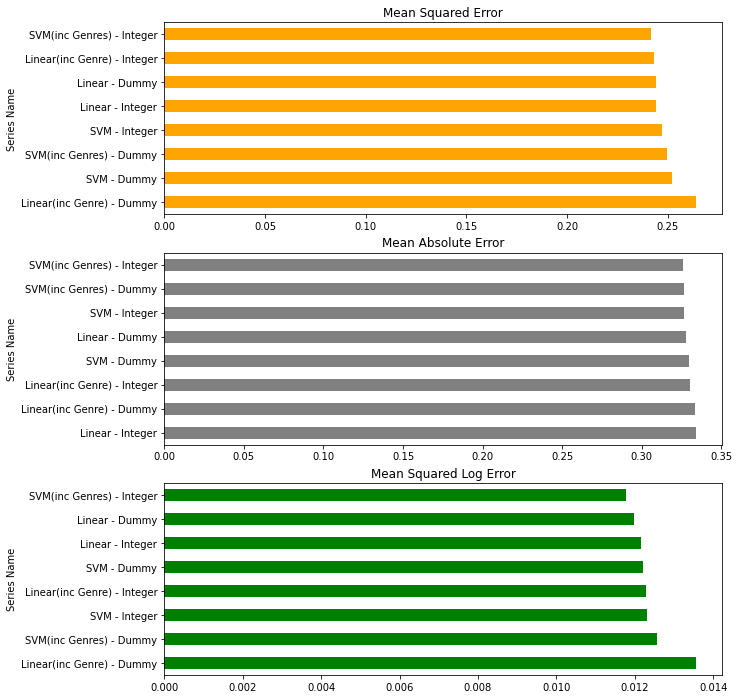

In [60]:
resultsdata.set_index('Series Name', inplace = True)

plt.figure(figsize = (10,12))
plt.subplot(3,1,1)
resultsdata['Mean Squared Error'].sort_values(ascending = False).plot(kind = 'barh',color=('orange'), title = 'Mean Squared Error')
plt.subplot(3,1,2)
resultsdata['Mean Absolute Error'].sort_values(ascending = False).plot(kind = 'barh',color=('grey'), title = 'Mean Absolute Error')
plt.subplot(3,1,3)
resultsdata['Mean Squared Log Error'].sort_values(ascending = False).plot(kind = 'barh',color=('green'), title = 'Mean Squared Log Error')
plt.show()

**Conclusion:** SVM (with encoded genres) performs the best in all three metrics as it should have due to additional important information, namely the genre of the application. 